**This Python 2 notebook extracts images of a Gallica document (using the IIIF protocol), and then applies an IBM Watson classification model to the images**
1. Extract the document bibliographical metadata from the Gallica OAI-PMH repository
2. Extract the document technical image metadata from its IIIF manifest, and then the images
3. Classify the images with a Watson Cloud Vision model (the model must be available)

<i>Prerequisites</i>:
- a pretrained  Watson Sudio classification model identified with its ID
- a Watson API key

In [1]:
# insert here the Gallica document ID you want to process
#docID = '12148/bpt6k46000341' # quotidien
#docID = '12148/btv1b6931954n' # photo
#docID = '12148/btv1b10336854c' # album
docID = '12148/btv1b10544068q' # estampe

In [2]:
import sys
print("Python version")
print (sys.version)

Python version
3.8.6 (default, Nov 16 2020, 11:50:36) 
[Clang 10.0.1 (clang-1001.0.46.4)]


### 1. We ask for the document IIIF manifest to know more about its images 

In [3]:
# we build the IIIF URL
import requests

METADATA_BASEURL = 'https://gallica.bnf.fr/iiif/ark:/'
req_url = "".join([METADATA_BASEURL, docID, '/manifest.json'])
print (req_url)

https://gallica.bnf.fr/iiif/ark:/12148/btv1b10544068q/manifest.json


In [4]:
# we ask for the manifest. The call returns a dictionary
r = requests.get(req_url)
r.raise_for_status()
json_4img = r.json()
print (json_4img.keys())

dict_keys(['@id', 'label', 'attribution', 'license', 'logo', 'related', 'seeAlso', 'description', 'metadata', 'sequences', 'thumbnail', '@type', '@context'])


### 2. Now we load the images files thanks to the IIIF Image protocol

In [10]:
from iiif_api import IIIF #  get the image files with the IIIF Image API (PyGallica package again)

# IIIF export factor (%)
docExportFactor = 15

# get the sequence of images metadata. It's a list
sequences = json_4img.get('sequences')
# get the canvases, first element of the list. Its a dict
canvases = sequences[0]
print (canvases.keys())
# parse each canvas data for each image
# each canvas has these keys: [u'height', u'width', u'@type', u'images', u'label', u'@id', u'thumbnail']
nImages = 0
urlsIIIF = []
print ("--- getting image metadata from the IIIF manifest...")
for c in canvases.get('canvases'): 
    nImages += 1
    print (" label:",c.get('label')," width:",c.get('width'), " height:",c.get('height'))
    # we also get a Gallica thumbnail (it's not a IIIF image)
    thumbnail = c.get('thumbnail')
    urlThumbnail = thumbnail.get('@id')
    #print " thumbnail: ",urlThumbnail  
    # we build the IIIF URL. We ask for the full image with a size factor of docExportFactor
    urlIIIF = "".join([docID,'/f',str(nImages)]), 'full', "".join(['pct:',str(docExportFactor)]), '0', 'native', 'jpg'
    urlsIIIF.append(urlIIIF)
    #IIIF.iiif()
     
print ("-------")
print ("images:", nImages)
[IIIF.iiif(u[0],u[1],u[2],u[3],u[4],u[5]) for u in urlsIIIF]


dict_keys(['canvases', 'label', '@type', '@id'])
--- getting image metadata from the IIIF manifest...
 label: NP  width: 3879  height: 5599
-------
images: 1
https://gallica.bnf.fr/iiif/ark:/12148/btv1b10544068q/f1/full/pct:15/0/native.jpg


[None]

### 3. We display the images 

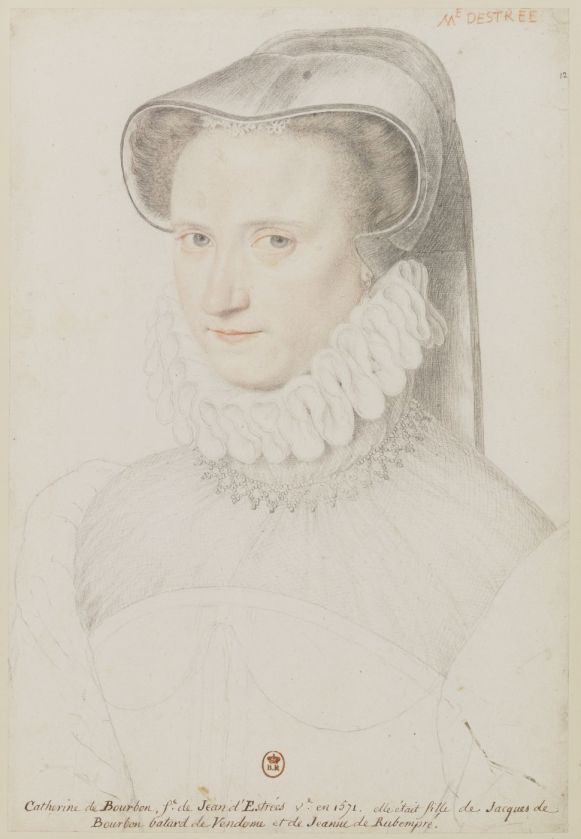

In [14]:
import io
from PIL import Image # pip install pillow
from PIL.Image import Image as PilImage
import matplotlib.pyplot as plt
import textwrap

def path_to_pil(file):   
    fileName = "".join([docID,"/",file]) # the images have been stored in a folder based on the document ID like 12148/btv1b103365619
    #print "--- loading image ",fileName,"..."
    img = Image.open(fileName)
    return img

def display_images(
    images, 
    columns=6, width=18, height=8, max_images=20, 
    label_wrap_length=20, label_font_size=8):

    if len(images) == 1:
        display(images[0])
        return 
    if not images:
        print ("No images to display!")
        return

    if len(images) > max_images:
        print ("Showing", max_images, " images of", len(images))
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)

        if hasattr(image, 'filename'):
            title=image.filename
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)
            plt.title(title, fontsize=label_font_size); 
            
# first we read the images
import os, fnmatch
entries = fnmatch.filter(os.listdir(docID), '*.jpg')
images = [path_to_pil(e) for e in entries]
display_images(images)
#for im in images:
#   display(im)




### 4. Now we process the images for face detection

 loading model...
**************
 12148/btv1b10544068q/f1.jpg
 165,122,186,265,1.00


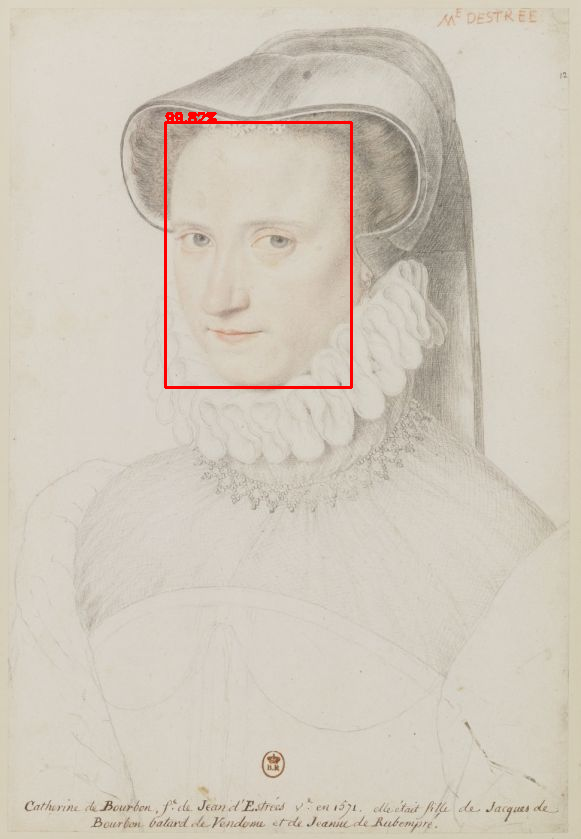

[None]

In [16]:
# using the dnn module : https://docs.opencv.org/master/d2/d58/tutorial_table_of_content_dnn.html

import numpy as np
import cv2
from imutils import paths

min_confidence = 0.25
nbFaces = 0

def process_image(im):
	# load the input image and construct an input blob for the image
	# by resizing to a fixed 300x300 pixels and then normalizing it
	image = cv2.imread(im.filename)
	(h, w) = image.shape[:2]
	blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,(300, 300), (104.0, 177.0, 123.0))
	outText=""
	print ("**************\n",im.filename)
	docID = im.filename[0:-4]
    
	global nbFaces
	# pass the blob through the network and obtain the detections and predictions
	net.setInput(blob)
	detections = net.forward()

	# loop over the detections
	for i in range(0, detections.shape[2]):
			# extract the confidence (i.e., probability) associated with the prediction
			confidence = detections[0, 0, i, 2]
			# filter out weak detections by ensuring the `confidence` is greater than the minimum confidence
			if (confidence > min_confidence):
				# compute the (x, y)-coordinates of the bounding box for the object
				box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
				(startX, startY, endX, endY) = box.astype("int")
				if ((endX>w) or (endY>h)):
					print (" out of image : %d %d") % (w,h)
				else:
					nbFaces += 1
					text = "{:.2f}%".format(confidence * 100)
					#print "\t%s" % text
					#print (startX, startY,(endX-startX),(endY-startY))
					# draw the boxes
					cv2.rectangle(image, (startX, startY), (endX, endY),(0, 0, 255), 2)
					cv2.putText(image, text, (startX, startY),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
					# build the csv data
					if (outText ==""):
						outText = " %d,%d,%d,%d,%.2f" % (startX, startY,(endX-startX), (endY-startY), confidence)
					else:
						outText = "%s\n %d,%d,%d,%d,%.2f" % (outText, startX, startY,(endX-startX), (endY-startY),confidence)

    # convert from openCV2 to PIL. Notice the COLOR_BGR2RGB which means that 
	# the color is converted from BGR to RGB
	color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	pil_image=Image.fromarray(color_coverted)
        
	if outText != "":
		print (outText)
		req_url = "".join([METADATA_BASEURL, docID, '/full'])
		#print req_url
        # show the output image
		#cv2.imshow("Output", image)
		#cv2.waitKey(0)     
	else:
		print ("\tno detection!")
        
	display(pil_image)
        
## Main ##       
print(" loading model...")
# Single Shot Detector (SSD) model / https://arxiv.org/abs/1512.02325
# https://towardsdatascience.com/review-ssd-single-shot-detector-object-detection-851a94607d11
net = cv2.dnn.readNetFromCaffe("deploy.prototxt.txt", "res10_300x300_ssd_iter_140000.caffemodel")
[process_image(im) for im in images]
